In [62]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM,Bidirectional
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras import optimizers
from keras.utils import plot_model,to_categorical
from keras.regularizers import l2

import pandas as pd
import numpy as np
import re

import score
from score import report_score

In [13]:
#Hyperparameters that were tuned after experiments
DATA_DIR = 'data/'
MAX_SEN_LEN = 150
MAX_VOCAB_SIZE = 30000
LSTM_DIM = 128
EMBEDDING_DIM = 200
BATCH_SIZE = 100
N_EPOCHS = 10
# REG_VALUE=0.001    

In [14]:
#Loading the dataset
train_bodies = pd.read_csv(DATA_DIR+'train_bodies.csv')
train_stances = pd.read_csv(DATA_DIR+'train_stances.csv')

test_bodies = pd.read_csv(DATA_DIR+'test_bodies.csv')
test_stances_unlabeled = pd.read_csv(DATA_DIR+'test_stances_unlabeled.csv')

train = train_stances.join(train_bodies.set_index('Body ID'), on='Body ID')
test = test_stances_unlabeled.join(test_bodies.set_index('Body ID'), on='Body ID')

In [15]:
#Pre-processing the dataset
def process_text(sen):    
    # Remove punctuations
    sentence = re.sub('[^a-zA-Z0-9]', ' ', sen)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [16]:
train['processed_headline']=train['Headline'].apply(process_text)
train['processed_body'] = train['articleBody'].apply(process_text)
test['processed_headline']=test['Headline'].apply(process_text)
test['processed_body'] = test['articleBody'].apply(process_text)

In [18]:
all_text = []
all_text.extend(list(train.processed_headline))
all_text.extend(list(train.processed_body))
all_text.extend(list(test.processed_headline))
all_text.extend(list(test.processed_body))
len(all_text)

150770

In [19]:
tokenizer = Tokenizer(MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(all_text)

In [21]:
train['head_body'] = train.processed_headline + train.processed_body
X_train = tokenizer.texts_to_sequences(train.head_body.values)
X_train = pad_sequences(X_train,padding='post',truncating='post',maxlen=MAX_SEN_LEN)

test['head_body'] = test.processed_headline + test.processed_body
X_test = tokenizer.texts_to_sequences(test.head_body.values)
X_test = pad_sequences(X_test,padding='post',truncating='post',maxlen=MAX_SEN_LEN)

In [25]:
competetion_bodies = pd.read_csv(DATA_DIR+'competition_test_bodies.csv')
competetion_stances = pd.read_csv(DATA_DIR+'competition_test_stances.csv')

# competetion_unlabeled = pd.read_csv(DATA_DIR+'competition_test_stances_unlabeled.csv')

comp = competetion_stances.join(competetion_bodies.set_index('Body ID'), on='Body ID')

In [22]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'species'.
y_train = label_encoder.fit_transform(train.Stance.values)
y_train = to_categorical(y_train)
y_train

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [26]:
y_actual = label_encoder.fit_transform(comp.Stance.values)
y_actual = to_categorical(y_actual)
y_actual

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [27]:
x_train,x_val,Y_train,Y_val = train_test_split(X_train,y_train,random_state=10, test_size=0.2)

In [28]:
# Creating word embedding matrix

import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

#GloVes Load

Glove = 'glove.6B.200d.txt'

glove2word2vec(glove_input_file=Glove, word2vec_output_file="gensim_glove_vectors.txt")
embeddings = gensim.models.KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings


In [31]:
optimizer = optimizers.Adam(lr=0.001)

In [34]:
# Build a sequential model by stacking neural net units 
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                        output_dim=EMBEDDING_DIM,
                        weights = [embeddings_matrix], trainable=True, name='word_embedding_layer' 
                        ))
model_lstm.add(LSTM(LSTM_DIM, return_sequences=False, name='lstm_layer'))
model_lstm.add(Dropout(rate=0.8, name='dropout_1')) # Can try varying dropout rates, in paper suggest 0.8
model_lstm.add(Dense(4, activation='softmax', name='output_layer'))

model_lstm.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
print(model_lstm.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 200)         5861600   
_________________________________________________________________
lstm_layer (LSTM)            (None, 128)               168448    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 516       
Total params: 6,030,564
Trainable params: 6,030,564
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
print("\n Fitting the model")

history = model_lstm.fit(x=x_train,y=Y_train,batch_size=BATCH_SIZE,epochs=N_EPOCHS,verbose=1,validation_data=(x_val,Y_val))



 Fitting the model
Epoch 1/10
400/400 [==============================] - 193s 483ms/step - loss: 0.7988 - accuracy: 0.7305 - val_loss: 0.6846 - val_accuracy: 0.7621
Epoch 2/10
400/400 [==============================] - 197s 492ms/step - loss: 0.6419 - accuracy: 0.7772 - val_loss: 0.5894 - val_accuracy: 0.7903
Epoch 3/10
400/400 [==============================] - 194s 484ms/step - loss: 0.5706 - accuracy: 0.7975 - val_loss: 0.5561 - val_accuracy: 0.7982
Epoch 4/10
400/400 [==============================] - 192s 481ms/step - loss: 0.5343 - accuracy: 0.8036 - val_loss: 0.5508 - val_accuracy: 0.8001
Epoch 5/10
400/400 [==============================] - 186s 466ms/step - loss: 0.5169 - accuracy: 0.8084 - val_loss: 0.5510 - val_accuracy: 0.7965
Epoch 6/10
400/400 [==============================] - 188s 470ms/step - loss: 0.4933 - accuracy: 0.8124 - val_loss: 0.5430 - val_accuracy: 0.7987
Epoch 7/10
400/400 [==============================] - 189s 471ms/step - loss: 0.4743 - accuracy: 0.8182 

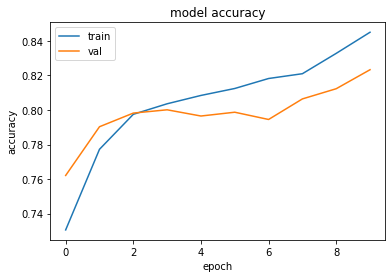

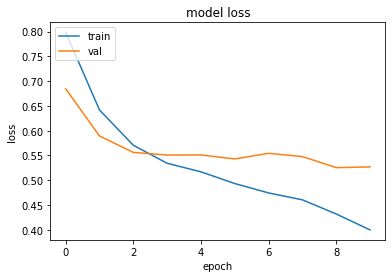

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [42]:
score = model_lstm.evaluate(x=X_test, y=y_actual, verbose=1)
y_predict = model_lstm.predict(x=X_test)
outputs = [np.argmax(p) for p in y_predict]
for i in range(len(outputs)):
    if outputs[i] == 0: outputs[i] = "agree"
    if outputs[i] == 1: outputs[i] = "disagree"
    if outputs[i] == 2: outputs[i] = "discuss"
    if outputs[i] == 3: outputs[i] = "unrelated"
print("Weighted scores on the test set")
report_score(comp.Stance.values,outputs)

Weighted scores on the test set
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    150    |     3     |    277    |   1473    |
-------------------------------------------------------------
| disagree  |    44     |     2     |    88     |    563    |
-------------------------------------------------------------
|  discuss  |    153    |     6     |   1043    |   3262    |
-------------------------------------------------------------
| unrelated |   1170    |     3     |   3586    |   13590   |
-------------------------------------------------------------
Score: 4735.25 out of 11651.25	(40.641562064156204%)


In [47]:
# Build a sequential model by stacking neural net units 
model_BiLstm = Sequential()
model_BiLstm.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=True, name='word_embedding_layer' 
                          ))
model_BiLstm.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=False, name='Bidrectional_lstm_layer1')))
model_BiLstm.add(Dropout(rate=0.8, name='dropout_1')) # Can try varying dropout rates, in paper suggest 0.8
model_BiLstm.add(Dense(4, activation='softmax', name='output_layer'))
model_BiLstm.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
print(model_BiLstm.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 200)         5861600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               336896    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 1028      
Total params: 6,199,524
Trainable params: 6,199,524
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
history_Bi = model_BiLstm.fit(x=x_train,y=Y_train,batch_size=BATCH_SIZE,epochs=N_EPOCHS,verbose=1,validation_data=(x_val,Y_val))

Epoch 1/10
400/400 [==============================] - 356s 890ms/step - loss: 0.6978 - accuracy: 0.7516 - val_loss: 0.5184 - val_accuracy: 0.8081
Epoch 2/10
400/400 [==============================] - 403s 1s/step - loss: 0.4650 - accuracy: 0.8254 - val_loss: 0.4027 - val_accuracy: 0.8477
Epoch 3/10
400/400 [==============================] - 438s 1s/step - loss: 0.3484 - accuracy: 0.8666 - val_loss: 0.3471 - val_accuracy: 0.8653
Epoch 4/10
400/400 [==============================] - 465s 1s/step - loss: 0.2752 - accuracy: 0.8953 - val_loss: 0.3026 - val_accuracy: 0.8875
Epoch 5/10
400/400 [==============================] - 395s 987ms/step - loss: 0.2196 - accuracy: 0.9171 - val_loss: 0.2774 - val_accuracy: 0.8982
Epoch 6/10
400/400 [==============================] - 381s 952ms/step - loss: 0.1729 - accuracy: 0.9355 - val_loss: 0.2616 - val_accuracy: 0.9100
Epoch 7/10
400/400 [==============================] - 366s 915ms/step - loss: 0.1496 - accuracy: 0.9453 - val_loss: 0.2520 - val_accu

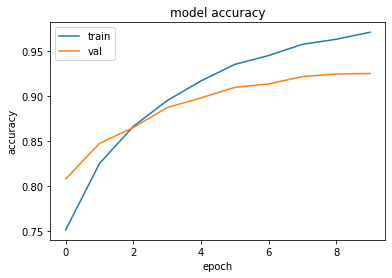

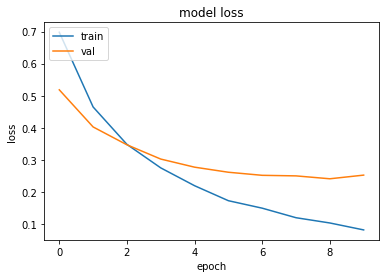

In [50]:
plt.plot(history_Bi.history['accuracy'])
plt.plot(history_Bi.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history_Bi.history['loss'])
plt.plot(history_Bi.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [52]:
score = model_BiLstm.evaluate(x=X_test, y=y_actual, verbose=1)
y_predict = model_BiLstm.predict(x=X_test)
outputs = [np.argmax(p) for p in y_predict]
for i in range(len(outputs)):
    if outputs[i] == 0: outputs[i] = "agree"
    if outputs[i] == 1: outputs[i] = "disagree"
    if outputs[i] == 2: outputs[i] = "discuss"
    if outputs[i] == 3: outputs[i] = "unrelated"
print("Weighted scores on the test set")
report_score(comp.Stance.values,outputs)

795/795 [==============================] - 118s 148ms/step - loss: 1.3564 - accuracy: 0.6490
Weighted scores on the test set
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    431    |    33     |    519    |    920    |
-------------------------------------------------------------
| disagree  |    111    |    11     |    170    |    405    |
-------------------------------------------------------------
|  discuss  |    296    |    15     |   2315    |   1838    |
-------------------------------------------------------------
| unrelated |    940    |    28     |   3644    |   13737   |
-------------------------------------------------------------
Score: 6477.25 out of 11651.25	(55.592747559274756%)


In [53]:
model_lstm.save("models/model_lstm.h5")
model_BiLstm.save("models/model_BiLstm.h5")